# Header

Imports

In [166]:
import os

# Data Processing Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# SentencePiece
import sentencepiece as spm

# Word2Vec
from gensim.models import Word2Vec
from gensim.models import FastText
import gensim.downloader

# Model Evaluation
from sklearn.model_selection import train_test_split

# Model Creation
import torch
import torch.nn as nn
import torch.optim as optim


from transformers import BertModel, BertTokenizer

In [167]:
# from transformers import BertModel, BertTokenizer
# model = BertModel.from_pretrained('bert-base-uncased',
#            output_hidden_states = True,)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def bert_text_preparation(text, tokenizer):
#   """
#   Preprocesses text input in a way that BERT can interpret.
#   """
#   marked_text = "[CLS] " + text + " [SEP]"
#   tokenized_text = tokenizer.tokenize(marked_text)
#   indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#   segments_ids = [1]*len(indexed_tokens)
# # convert inputs to tensors
#   tokens_tensor = torch.tensor([indexed_tokens])
#   segments_tensor = torch.tensor([segments_ids])
#   return tokenized_text, tokens_tensor, segments_tensor

# def get_bert_embeddings(tokens_tensor, segments_tensor, model):
#     """
#     Obtains BERT embeddings for tokens.
#     """
#     # gradient calculation id disabled
#     with torch.no_grad():
#       # obtain hidden states
#       outputs = model(tokens_tensor, segments_tensor)
#       hidden_states = outputs[2]
#     # concatenate the tensors for all layers
#     # use "stack" to create new dimension in tensor
#     token_embeddings = torch.stack(hidden_states, dim=0)
#     # remove dimension 1, the "batches"
#     token_embeddings = torch.squeeze(token_embeddings, dim=1)
#     # swap dimensions 0 and 1 so we can loop over tokens
#     token_embeddings = token_embeddings.permute(1,0,2)
#     # intialized list to store embeddings
#     token_vecs_sum = []
#     # "token_embeddings" is a [Y x 12 x 768] tensor
#     # where Y is the number of tokens in the sentence
#     # loop over tokens in sentence
#     for token in token_embeddings:
#     # "token" is a [12 x 768] tensor
#     # sum the vectors from the last four layers
#         sum_vec = torch.sum(token[-4:], dim=0)
#         token_vecs_sum.append(sum_vec)
#     return token_vecs_sum

# sentences = ["bank",
#          "he eventually sold the shares back to the bank at a premium.",
#          "the bank strongly resisted cutting interest rates.",
#          "the bank will supply and buy back foreign currency.",
#          "the bank is pressing us for repayment of the loan.",
#          "the bank left its lending rates unchanged.",
#          "the river flowed over the bank.",
#          "tall, luxuriant plants grew along the river bank.",
#          "his soldiers were arrayed along the river bank.",
#          "wild flowers adorned the river bank.",
#          "two fox cubs romped playfully on the river bank.",
#          "the jewels were kept in a bank vault.",
#          "you can stow your jewellery away in the bank.",
#          "most of the money was in storage in bank vaults.",
#          "the diamonds are shut away in a bank vault somewhere.",
#          "thieves broke into the bank vault.",
#          "can I bank on your support?",
#          "you can bank on him to hand you a reasonable bill for your services.",
#          "don't bank on your friends to help you out of trouble.",
#          "you can bank on me when you need money.",
#          "i bank on your help."
#          ]
# from collections import OrderedDict
# context_embeddings = []
# context_tokens = []
# for sentence in sentences:
#   tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
#   list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
#   # make ordered dictionary to keep track of the position of each   word
#   tokens = OrderedDict()
#   # loop over tokens in sensitive sentence
#   for token in tokenized_text[1:-1]:
#     # keep track of position of word and whether it occurs multiple times
#     if token in tokens:
#       tokens[token] += 1
#     else:
#       tokens[token] = 1
#   # compute the position of the current token
#     token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
#     current_index = token_indices[tokens[token]-1]
#   # get the corresponding embedding
#     token_vec = list_token_embeddings[current_index]
    
#     # save values
#     context_tokens.append(token)
#     context_embeddings.append(token_vec)


In [168]:
# from transformers import BertModel, BertTokenizer
# import torch
# import pandas as pd

# # Load the model and tokenizer
# model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def bert_text_preparation(text, tokenizer):
#     marked_text = "[CLS] " + text + " [SEP]"
#     tokenized_text = tokenizer.tokenize(marked_text)
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#     segments_ids = [1] * len(indexed_tokens)
#     tokens_tensor = torch.tensor([indexed_tokens])
#     segments_tensor = torch.tensor([segments_ids])
#     return tokens_tensor, segments_tensor

# def get_bert_embeddings(tokens_tensor, segments_tensor, model):
#     with torch.no_grad():
#         outputs = model(tokens_tensor, segments_tensor)
#         hidden_states = outputs[2]
#     token_embeddings = torch.stack(hidden_states, dim=0)
#     token_embeddings = torch.squeeze(token_embeddings, dim=1)
#     token_embeddings = token_embeddings.permute(1, 0, 2)
    
#     # For sentence vector, use mean of the second to last layer of each token.
#     sentence_embedding = torch.mean(token_embeddings[:, -2, :], dim=0)
    
#     return sentence_embedding

# # Your sentences
# sentences = ["Example sentence 1", "Example sentence 2"]  # Add all your sentences here

# # Initialize list to store embeddings
# sentence_embeddings = []

# # Generate embeddings
# for sentence in sentences:
#     tokens_tensor, segments_tensor = bert_text_preparation(sentence, tokenizer)
#     sentence_embedding = get_bert_embeddings(tokens_tensor, segments_tensor, model)
#     sentence_embeddings.append(sentence_embedding.numpy())  # Convert to numpy array and store

# # Create DataFrame
# df = pd.DataFrame({'sentences': sentences, 'vectors': sentence_embeddings})

# print(df)


Preprocessing Data Functions

In [169]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence
        
def get_sentence_tokens(sentence, sp):
    '''Gets the word tokens of a given sentence by tokenising'''
    tokens = sp.encode_as_pieces(sentence)
    return tokens

def get_avg_vector_for_sent(tokens, model):
    '''Uses the Word2Vec LUT to get the vector representation of a tokens 
       in a sentence and takes the mean'''
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model.wv:
            vector += model.wv[token]
    if len(tokens) > 0: 
        vector /= len(tokens)
    return vector
    
def sentence_to_vector(sentence, model,sp):
    '''Returns the vector representation of a sentence
       by taking the average of the Word2Vec representations of the 
       words / subwords'''
    tokens = get_sentence_tokens(sentence,sp)
    vector = get_avg_vector_for_sent(tokens, model)
    return vector

def train_fasttext_model(tokenized_texts, vector_size=25):
    fasttext_model = FastText(sentences=tokenized_texts, vector_size=vector_size, window=5, min_count=1, workers=4, sg=1)  # sg=1 means skip-gram
    return fasttext_model

def fasttext_sentence_to_vector(sentence, model):
    '''Directly uses FastText to get the vector representation of a sentence'''
    # Splitting the sentence into words; this could be replaced or refined as needed
    tokens = sentence.split()  
    vector = np.zeros(model.vector_size)
    for token in tokens:
        vector += model.wv[token]  # FastText will handle OOV words using n-grams
    if len(tokens) > 0: 
        vector /= len(tokens)
    return vector

def ngrams(word, min_n=3, max_n=6):
    """Generate n-grams for a word."""
    extended_word = f"<{word}>"
    ngrams = [extended_word[i:i+n] for n in range(min_n, max_n+1) for i in range(len(extended_word)-n+1)]
    return list(set(ngrams))

def fasttext_oov_word_vector(word, model, min_n=3, max_n=6):
    """Construct a vector for an OOV word by averaging its n-grams that are in the model.
       If no n-grams are found in the model, return a zero vector."""
    word_ngrams = ngrams(word, min_n, max_n)
    vector = np.zeros(model.vector_size)
    valid_ngrams = 0
    for ngram in word_ngrams:
        if ngram in model:
            vector += model[ngram]
            valid_ngrams += 1
    if valid_ngrams > 0:
        vector /= valid_ngrams
    else:
        # Return a zero vector if no valid n-grams are found
        vector = np.zeros(model.vector_size)
    return vector

def pt_fasttext_sentence_to_vector(sentence, model, min_n=3, max_n=6):
    """Get the vector representation of a sentence by averaging the vectors of its words.
       Handles OOV words by constructing their vectors from subwords or using a zero vector if necessary."""
    tokens = sentence.split()  # Splitting the sentence into words; refine as needed
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model:
            vector += model[token]
        else:
            # Attempt to construct the vector for OOV word from its n-grams or use a zero vector
            vector += fasttext_oov_word_vector(token, model, min_n, max_n)
    if len(tokens) > 0:
        vector /= len(tokens)
    return vector




Preprocessing to Model Functions

Model Creation

In [170]:
class UpvotesPredictorNN(nn.Module):
    def __init__(self, word_dimensionality):
        super(UpvotesPredictorNN, self).__init__()
        
        # Input layer to 1st hidden layer
        self.fc1 = nn.Linear(word_dimensionality, 128)
        self.relu1 = nn.ReLU()
        
        # 1st hidden layer to 2nd hidden layer
        self.fc2 = nn.Linear(128, 32)
        self.relu2 = nn.ReLU()
        
        # 2nd hidden layer to output layer
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        output = self.output(x)
        return output

# Main Execution

Set Env

In [171]:
if os.sys.platform == 'darwin':      # MacOS
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif os.sys.platform == 'win32':    # Windows
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:                               # other OS
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mps


Load Dataset

In [172]:
file_path = './data/TitlesAndScoreALL.csv'
data_df = pd.read_csv(file_path, sep=',')

Set Embedding Dim

In [173]:
word_dimensionality = 300

Generate Embeddings

In [174]:
def ngrams(word, min_n=3, max_n=6):
    """
    Generate n-grams for a word.
    """
    extended_word = f"<{word}>"
    ngrams = [extended_word[i:i+n] for n in range(min_n, max_n+1) for i in range(len(extended_word)-n+1)]
    return list(set(ngrams))

def fasttext_oov_word_vector(word, model, min_n=3, max_n=6):
    """
    Construct a vector for an OOV word by averaging its n-grams that are in the model.
    """
    word_ngrams = ngrams(word, min_n, max_n)
    vector = np.zeros(model.vector_size)
    valid_ngrams = 0
    for ngram in word_ngrams:
        if ngram in model:
            vector += model[ngram]
            valid_ngrams += 1
    if valid_ngrams > 0:
        vector /= valid_ngrams
    return vector

def pt_fasttext_sentence_to_vector(sentence, model, min_n=3, max_n=6):
    """
    Get the vector representation of a sentence by averaging the vectors of its words.
    Handles OOV words by constructing their vectors from subwords.
    """
    tokens = sentence.split()  # Splitting the sentence into words; refine as needed
    vector = np.zeros(model.vector_size)
    for token in tokens:
        if token in model:
            vector += model[token]
        else:
            # Attempt to construct the vector for OOV word from its n-grams
            vector += fasttext_oov_word_vector(token, model, min_n, max_n)
    if len(tokens) > 0:
        vector /= len(tokens)
    return vector


In [175]:
w2v_df = data_df.copy()
ft_df = data_df.copy()
pt_df = data_df.copy()
bert_df = data_df.copy()

In [176]:
spm.SentencePieceTrainer.train(
    sentence_iterator=dataframe_sentence_generator(data_df['title']), 
    vocab_size=12_828,
    model_prefix='./data/spm_model', 
    model_type='word',
)
sp = spm.SentencePieceProcessor()
sp.load('./data/spm_model.model')

tokenized_titles = [sp.encode_as_pieces(title) for title in data_df['title']]

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: ./data/spm_model
  model_type: WORD
  vocab_size: 12828
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differential

In [177]:
# Unigram tokens, word2vec
word2vec_model = Word2Vec(sentences=tokenized_titles, vector_size=word_dimensionality, window=5, min_count=1, workers=4, sg=1)
w2v_df['sentence_vector'] = w2v_df['title'].apply(lambda x: sentence_to_vector(x, word2vec_model, sp))

In [178]:
# Untrained tokens, fasttext
fasttext_model = FastText(sentences=ft_df['title'], vector_size=word_dimensionality, window=5, min_count=1, workers=4, sg=1)
ft_df['sentence_vector'] = ft_df['title'].apply(lambda x: fasttext_sentence_to_vector(x, fasttext_model))

KeyboardInterrupt: 

(OR) Load Embeddings

In [ ]:
# Pretrained tokens, fasttext
vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')
pt_df['sentence_vector'] = pt_df['title'].apply(lambda x: pt_fasttext_sentence_to_vector(x, vectors))

In [188]:
# Pretrained tokens, BERT
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_text_preparation(text, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    return tokens_tensor, segments_tensor

def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1, 0, 2)
    
    # For sentence vector, use mean of the second to last layer of each token.
    sentence_embedding = torch.mean(token_embeddings[:, -2, :], dim=0)
    
    return sentence_embedding

bert_df = bert_df.iloc[:10]
sentences = list(bert_df['title'])

sentence_embeddings = []

for sentence in sentences:
    tokens_tensor, segments_tensor = bert_text_preparation(sentence, tokenizer)
    sentence_embedding = get_bert_embeddings(tokens_tensor, segments_tensor, model)
    sentence_embeddings.append(sentence_embedding.numpy())

bert_df['sentence_vector'] = sentence_embeddings

Train Test Split

In [ ]:
def data_split(data_df):
    # Split the data into training and test sets
    X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
        data_df['sentence_vector'].tolist(), 
        data_df['score'], 
        test_size=0.3, 
        random_state=42
    )

    X_test, X_val, y_test, y_val = train_test_split(
        X_test_and_val, 
        y_test_and_val, 
        test_size=0.5, 
        random_state=42
    )

    X_train = torch.tensor(np.vstack(X_train), dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)

    X_val = torch.tensor(np.vstack(X_val), dtype=torch.float32).to(device)
    y_val = torch.tensor(np.array(y_val), dtype=torch.float32).view(-1, 1)

    X_test = torch.tensor(np.vstack(X_test), dtype=torch.float32).to(device)
    y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def train_loop(X_train, X_test, X_val, y_train, y_test, y_val, word_dimensionality):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
        
    # Define model and hyperparameters
    model = UpvotesPredictorNN(word_dimensionality=word_dimensionality).to(device)
    criterion = nn.MSELoss()
    num_epochs = 200
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Storage object for data vis
    list_of_lists = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()
        
        
        # Set model to evaluation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            predictions = model(X_val)
            val_loss = criterion(predictions, y_val)
        
        # Store loss for data vis
        list_of_lists.append([epoch, loss.item(), val_loss.item()])
        
        # # Logging
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1},\t Train Loss: {loss.item()},\t Val Loss: {val_loss.item()}')
            
    return list_of_lists, model, criterion, X_test, y_test
    

In [ ]:
def plot(results):
    list_of_lists, model, criterion, X_test, y_test = results
    
    X_test =X_test.to(device)
    y_test = y_test.to(device)
    
    train_loss_list = []
    val_loss_list = []
    epoch_list = []
    
    for i,j,k in list_of_lists:
        epoch_list.append(i)
        train_loss_list.append(j)
        val_loss_list.append(k)
        
    with torch.no_grad():
            model.eval()
            predictions = model(X_test)
            test_loss = criterion(predictions, y_test) 
    
    print(f'Test Loss: {test_loss.item()}')
        
    return epoch_list, train_loss_list, val_loss_list

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split(w2v_df)
# w2v_results = train_loop(X_train, X_test, X_val, y_train, y_test, y_val, word_dimensionality)
# w2v_plot = plot(w2v_results)
# X_train, X_val, X_test, y_train, y_val, y_test = data_split(ft_df)
# ft_df_results = train_loop(X_train, X_test, X_val, y_train, y_test, y_val, word_dimensionality)
# ft_plot = plot(ft_df_results)
# X_train, X_val, X_test, y_train, y_val, y_test = data_split(pt_df)
# pt_df_results = train_loop(X_train, X_test, X_val, y_train, y_test, y_val, word_dimensionality)
# pt_plot = plot(pt_df_results)
bert_results = train_loop(X_train, X_test, X_val, y_train, y_test, y_val, word_dimensionality)
bert_plot = plot(bert_results)

Epoch 1,	 Train Loss: 319.24993896484375,	 Val Loss: 350.7054748535156
Epoch 101,	 Train Loss: 265.0168151855469,	 Val Loss: 296.9208984375
Epoch 201,	 Train Loss: 261.0811767578125,	 Val Loss: 292.62890625
Epoch 301,	 Train Loss: 259.46099853515625,	 Val Loss: 291.0541687011719
Epoch 401,	 Train Loss: 258.0389099121094,	 Val Loss: 290.2515869140625
Epoch 501,	 Train Loss: 256.74505615234375,	 Val Loss: 289.7600402832031
Epoch 601,	 Train Loss: 255.7157745361328,	 Val Loss: 289.5066833496094
Epoch 701,	 Train Loss: 254.62086486816406,	 Val Loss: 289.08355712890625
Epoch 801,	 Train Loss: 253.6951446533203,	 Val Loss: 288.9676513671875
Epoch 901,	 Train Loss: 252.895263671875,	 Val Loss: 288.958251953125
Epoch 1001,	 Train Loss: 252.02439880371094,	 Val Loss: 288.97955322265625
Epoch 1101,	 Train Loss: 251.08152770996094,	 Val Loss: 289.1837463378906
Epoch 1201,	 Train Loss: 249.99420166015625,	 Val Loss: 289.44580078125
Epoch 1301,	 Train Loss: 249.07644653320312,	 Val Loss: 289.804229

KeyboardInterrupt: 

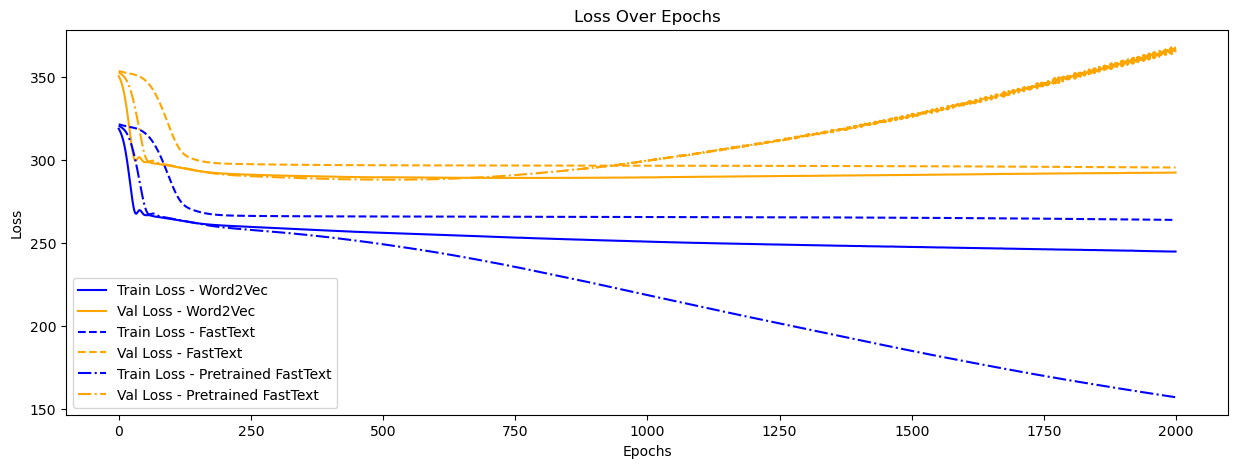

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Labels for each plot for clarity
labels = ['Word2Vec', 'FastText', 'Pretrained FastText']
linestyles = ['-', '--', '-.']

for i, (epoch_list, train_loss_list, val_loss_list) in enumerate([w2v_plot, ft_plot, pt_plot]):
    # Plot training and validation loss for each model
    ax.plot(epoch_list, train_loss_list, label=f'Train Loss - {labels[i]}', linestyle=linestyles[i], color='blue')
    ax.plot(epoch_list, val_loss_list, label=f'Val Loss - {labels[i]}', linestyle=linestyles[i], color='orange')

# Set the title and labels
ax.set_title('Loss Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

# Enable the legend
ax.legend()

# Show the plot
plt.show()
